<a href="https://colab.research.google.com/github/nyp-sit/iti107/blob/main/session-2/1.data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

Welcome to this week's programming exercise. In this week's exercises, we will learn how to improve our model performance using common tecniques such as data augmentation and transfer learning.

Data augmentation is typically used when you have a small set of training samples. It allows you to increase your number of samples by generating artificial samples, either based on some random transformation of your existing samples, or by some statistical means. The larger training samples can help the model to generalize better.


In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

### Create train and validation dataset

We will be using the flower dataset from Tensorflow datasets. Let's go ahead and prepare our train and validation dataset.

In [2]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
path_to_zip = tf.keras.utils.get_file(origin=dataset_url, extract=True, cache_dir='.')

228813984/228813984 [==============================] - 1s 0us/step


In [3]:
dataset_folder = os.path.dirname(path_to_zip)
dataset_folder = os.path.join(dataset_folder, 'flower_photos')

In [4]:
batch_size = 32
image_size = (128,128)

# label_mode is set to 'int' as the dataset is multi-class
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [5]:
print(val_ds.class_names)
num_classes = len(val_ds.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Data Augmentation

Since tensorflow 2.2, Keras introduces new types of layers for doing image data augmentation, such as Random Cropping, Random Flipping, etc. Previously, we have to depend on ImageDataGenerator() (which is a lot slower) to do so.

In the code below, we create a Sequential model to add the image augmentation layer: `RandomRotation()`. The value `0.1' refers to the maximum rotation angle in both clock-wise and anti-clockwise direction. You can find out more info from the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation)

In [6]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(0.1),
    ]
)

To see the effects of data augmentation, let us apply our data_augmentation layer to a sample image.

(1, 128, 128, 3)


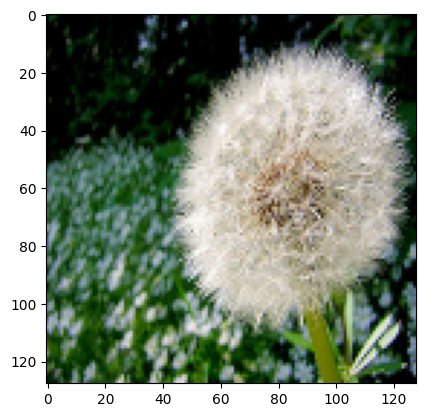

In [7]:
images, _ = next(train_ds.take(1).as_numpy_iterator())
sample_image = images[0]/255.
plt.imshow(sample_image)
sample_image = tf.expand_dims(sample_image, 0)
print(sample_image.shape)

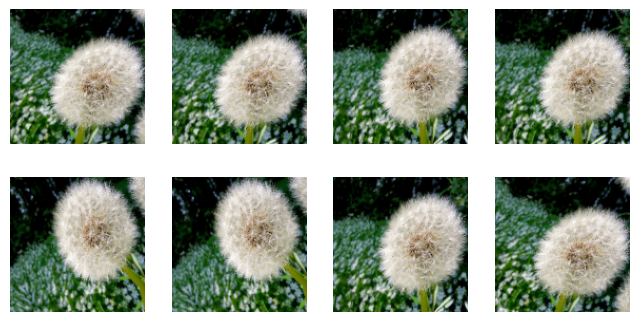

In [8]:
plt.figure(figsize=(8, 4))
for i in range(8):
    augmented_image = data_augmentation(sample_image)
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

**Exercise 1:**

Modify the code above to add in [random Horizontal flip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip).

<details><summary>Click here for answer</summary>

```python
    
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.1),
        layers.RandomFlip("horizontal")
    ]
)    
```
    
</details>

In [9]:
## TODO: Modify the code to add data augmentation
data_augmentation = keras.Sequential(
        [
            tf.keras.layers.RandomRotation(0.1)
        ]
    )

## Build the model

We will use the mini Xception network that we built in previous lab and use it to classify our flow dataset. The codes for xception block is given below.


In [10]:
def xception_block(x, depth):

    residual = x

    x = keras.layers.SeparableConv2D(depth, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.SeparableConv2D(depth, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPool2D(3, strides=2, padding='same')(x)

    residual = keras.layers.Conv2D(depth, 1, strides=2, padding='same')(residual)

    x = keras.layers.add( [x, residual] )

    x = keras.layers.Activation('relu')(x)

    return x


**Exercise 2:**

Modify the code in `make_model()` to apply data augmention layers you have created earlier. Where should you place your augmentation layer?  

<details><summary>Click here for answer</summary>

```python
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)    
    
    ## Add your augmentation layers here !!
    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)

    ## the rest of the codes....
    
    return keras.Model(inputs, outputs)    
```
    
</details>

In [11]:
##TODO: Modify the code below to add in the data augmentation layer
def make_model(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)

    # add resclaing
    x = keras.layers.Rescaling(1./255)(inputs)

    # 1st conv2d with strides = 2
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # 2nd conv2d with strides = 1
    x = keras.layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # build a series of xception blocks with different depth
    for depth in [128, 256, 512, 728]:
        x = xception_block(x, depth)

    # add SeparableConv2D
    x = keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # add Global Average Pooling layer before connecting to Dense layer
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dropout(0.5)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

In [12]:
model = make_model(input_shape= image_size + (3,), num_classes=num_classes)

## Train the model

Let's train our new model with the data augmentation layer.  We increase our training epochs to 50 to give our model more chances to see the augmented images.

In [13]:
def create_tb_callback():

    import os

    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run

        import time

        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# compile our model with loss and optimizer
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model.fit(
    train_ds, epochs=50,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, create_tb_callback()]
)

Epoch 1/50
92/92 [==============================] - 37s 116ms/step - loss: 1.1924 - accuracy: 0.5395 - val_loss: 1.6294 - val_accuracy: 0.2493
Epoch 2/50
92/92 [==============================] - 9s 90ms/step - loss: 0.8984 - accuracy: 0.6540 - val_loss: 1.8559 - val_accuracy: 0.2493
Epoch 3/50
92/92 [==============================] - 8s 83ms/step - loss: 0.7487 - accuracy: 0.7183 - val_loss: 2.3865 - val_accuracy: 0.2493
Epoch 4/50
92/92 [==============================] - 8s 88ms/step - loss: 0.6505 - accuracy: 0.7643 - val_loss: 2.9056 - val_accuracy: 0.2493
Epoch 5/50
92/92 [==============================] - 8s 87ms/step - loss: 0.5499 - accuracy: 0.8048 - val_loss: 3.5293 - val_accuracy: 0.2493
Epoch 6/50
92/92 [==============================] - 8s 86ms/step - loss: 0.3979 - accuracy: 0.8634 - val_loss: 2.4256 - val_accuracy: 0.2943
Epoch 7/50
92/92 [==============================] - 11s 112ms/step - loss: 0.3332 - accuracy: 0.8784 - val_loss: 1.4071 - val_accuracy: 0.5790
Epoch 8/5

KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

In [ ]:
best_checkpoint = 'best_checkpoint'

model.load_weights(best_checkpoint)
model.evaluate(val_ds)

**Exercise**

You can try to add in more data augmentation e.g. random cropping, or changing the contrast.
Does additional augmentation improve your model?  What do you observe?


<details><summary>Click here for answer</summary>
Our model is still clearly overfitting, even though we have used data augmentation. The augmented images are still heavily correlated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As next step to improve our accuracy on this problem, we will have to leverage transfer learning using pre-trained model, which will be the focus of the lesson.
</details>